--- NOTES ---

- 1 ns unit for time
- Conventions:
  - [qubit, resonator 1, resonator 2]
  - Qubit, pump: blue
  - Resonator 1, coupling 1: green
  - Resonator 2, coupling 2: red

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import plots
import os
import shutil
import time
from datetime import datetime
from glob import glob
from copy import copy
from supports import *
from envelopes import *
from process import *
from plotsettings import *
from qutip import *
from scipy.special import erf
from scipy.signal import argrelextrema

pi = np.pi
exp = np.exp
sqrt = np.sqrt
hbar = 1.0546e-34*1e-9  # reduced Planck constant
All = 'all'
options = Options()

In [2]:
Nq = 4   # number of levels in qubit
N1 = 10  # number of levels in resonator 1
N2 = 10  # number of levels in resonator 2

wq = 7*2*pi  # qubit frequency
wp = wq  # pump frequency
w1 = wq  # resonator 1 frequency
w2 = wq  # resonator 2 frequency

kq = 50e-6*2*pi  # photon emission frequency of qubit (qubit decay rate)
k1 = 10e-6*2*pi  # photon emission freqency of resonator 1 (resonator 1 decay rate)
k2 = 8e-3*2*pi   # photon emission frequency of resonator 2 (resonator 2 decay rate)

g1 = 400e-6*2*pi  # drive frequency resonator 1, coupling between qubit and resonator 1
g2 = 3e-3*2*pi    # drive frequency resonator 2, coupling between qubit and resonator 2

chi1 = 30e-6*2*pi   # state-dependent frequency shift of resonator 1
chi2 = 500e-6*2*pi  # state-dependent frequency shift of resonator 2
delta = 0

Ec = 0.16*2*pi  # Anharmonicity (charging energy)

In [3]:
t0 = 0         # start Gaussian pulse Omega
t1 = t0 + 50   # end Gaussian pulse Omega
t2 = t1 + 10   # start square pulse at resonator 1
t3 = t2 + 200  # end square pulse at resonator 1
t4 = t3 + 10   # start square pulse at resonator 2
t5 = t4 + 168  # end square pulse at resonator 2
t6 = t5 + 10   # t0
tg = 10        # Gaussian rise and fall time of square pulse

N_repeat = 10  # number of times to repeat cycle
Np = int(t6)     # number of discrete time steps per cycle for which to store the output
smooth = False  # square pulses rise and fall with Gaussian
Q = 3  # number of std's in Gaussian curves, rises and falls

In [4]:
# Qubit operators
b = tensor(destroy(Nq), qeye(N1), qeye(N2))
nq = b.dag()*b
sx = tensor(sigmax(), qeye(N1), qeye(N2)) # x-projection of qubit level
sy = tensor(sigmay(), qeye(N1), qeye(N2)) # y-projection of qubit level
sz = tensor(sigmaz(), qeye(N1), qeye(N2)) # z-projection of qubit level

# Cavity operators
a1 = tensor(qeye(Nq), destroy(N1), qeye(N2))
a2 = tensor(qeye(Nq), qeye(N1), destroy(N2))
n1 = a1.dag()*a1
n2 = a2.dag()*a2

# Jaynes-Cummings Hamiltonian (not the measurement hamiltonian)
Hjc = ( (w1-wq)*(w1*a1.dag()*a1) + (w2-wq)*(w2*a2.dag()*a2)
      - Ec/2*b.dag()*b.dag()*b*b 
      - chi1*nq*n1 - chi2*nq*n2 - delta*nq )

# Coupling Hamiltonians (only red sideband transitions)
H1 = g1*(a1*b.dag() + b*a1.dag())
H2 = g2*(a2*b.dag() + b*a2.dag())

# Hamiltonian arguments
H_args = {"t0" : t0, "t1" : t1, "t2" : t2, "t3" : t3, 
          "t4" : t4, "t5" : t5, "t6" : t6, "tg" : tg,
          "g1" : g1, "g2" : g2, "Q"  : Q,  "Np" : Np,
          "N_repeat" : N_repeat, "gauss" : True, "smooth" : True}

# Pump Hamiltonian
rotation = 0.5  # Rabi pulse (*pi)
Omega = rotation*pump_strength(H_args)
H_args['Omega'] = Omega
Hp = Omega/2*(b + b.dag())  # including rotating frame

In [5]:
# Collapse operators, losses
cq = sqrt(kq)*b   # qubit
c1 = sqrt(k1)*a1  # resonator 1
c2 = sqrt(k2)*a2  # resonator 2
c_ops = [cq, c1, c2]

# Expectation operators
e_ops = [nq, n1, n2]

In [6]:
H = [Hjc, [Hp, pump], [H1, square1], [H2, square2]]  # complete Hamiltonian
psi0 = tensor(basis(Nq,0), basis(N1,0), basis(N2,0))  # initial state

# Select these options for bdf method
# options.method = 'bdf'
# options.rtol = 1e-14

# Select these options for adams method
options.nsteps = 10000
options.rtol = 10e-9
options.max_step = 0.1

options.store_states=True

Np_per_batch = Np/10  # number of time points per batch

In [1]:
batches = create_batches(0, N_repeat*t6, N_repeat*Np, Np_per_batch)

# Remove existing progress folder
for folder in glob("/home/student/thesis/temp/prog_*"):
    shutil.rmtree(folder)

# Make new progress folder
now = datetime.now().strftime("%y_%m_%d_%H_%M_%S")
folder = "/home/jovyan/thesis/temp/prog_" + now
os.makedirs(folder)

# Calculate!
for num, tlist in enumerate(batches):
    print(num+1, "/", len(batches), ":", int(np.round(100*(num+1)/len(batches))), "%")
    result = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops, args=H_args, options=options)
    saveprog(result, None, None, None, None, None, num, folder)
    psi0 = copy(result.states[-1])
    del result
print("Evolution completed")
combine_batches(folder, quants=['times', 'expect'], return_data=False)
print("Batches combined")

In [8]:
tfile = open(folder + "/times.pkl", 'rb')
tdata = pickle.load(tfile)
times = tdata['data']
tfile.close()

# sfile = open(folder + "/states.pkl", 'rb')
# sdata = pickle.load(sfile)
# states = sdata['data']
# sfile.close()

efile = open(folder + "/expect.pkl", 'rb')
edata = pickle.load(efile)
expect = edata['data']
efile.close()

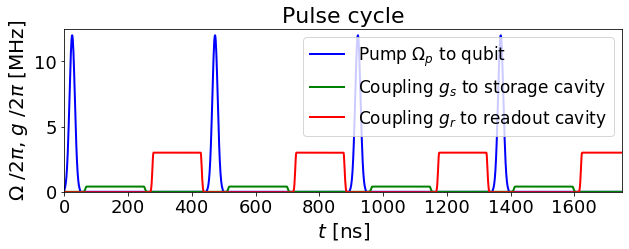

In [9]:
pump_pulse = Omega/(2*pi)*1000*pump(times, H_args)
sqr1_pulse = g1/(2*pi)*1000*square1(times, H_args)
sqr2_pulse = g2/(2*pi)*1000*square2(times, H_args)
plt.figure(figsize=(10, 3))
plt.plot(times, pump_pulse, color='b', label='Pump $\\Omega_p$ to qubit')
plt.plot(times, sqr1_pulse, color='g', label='Coupling $g_s$ to storage cavity')
plt.plot(times, sqr2_pulse, color='r', label='Coupling $g_r$ to readout cavity')
plt.xlim([0, 1750])
plt.ylim([0,12.5])
plt.xlabel("$t$ [ns]")
plt.ylabel("$\\Omega$ $/2\\pi$, $g$ $/2\\pi$ [MHz]")
plt.title("Pulse cycle")
plt.legend()
plt.show()

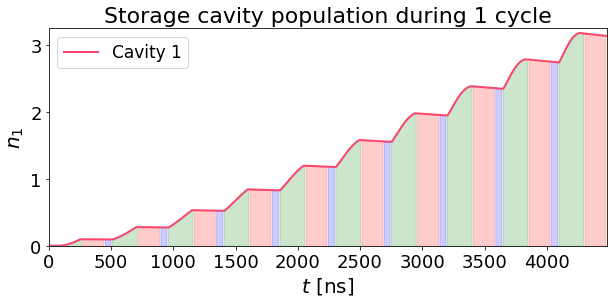

In [14]:
obj = 1    # 0 = qubit, 1 = cavity 1, 2 = cavity 2
ind = int(300/2)  # index of tlist

plt.figure(figsize=(10, 4))
if obj == 0:
    plt.plot(times, expect[obj], color=plotcolours['qubit'], label='Qubit')
elif obj == 1:
    plt.plot(times, expect[obj], color=plotcolours['cavity1'], label='Cavity 1')
for i in range(N_repeat):
    plt.fill_between(times[int((i*t6+t0)):int((i*t6+t1))], expect[obj][int((i*t6+t0)):int((i*t6+t1))], alpha=0.2, color='b')
    plt.fill_between(times[int((i*t6+t2)):int((i*t6+t3))], expect[obj][int((i*t6+t2)):int((i*t6+t3))], alpha=0.2, color='g')
    plt.fill_between(times[int((i*t6+t4)):int((i*t6+t5))], expect[obj][int((i*t6+t4)):int((i*t6+t5))], alpha=0.2, color='r')

# VARIABLE PLOT SETTINGS    
plt.xlim([0, max(times)])
plt.ylim([0, 3.25])

plt.xlabel("$t$ [ns]")
if obj > 0:
    plt.ylabel("$n_{}$".format(obj))
    plt.title("Storage cavity population during 1 cycle")
else:
    plt.ylabel("$\\left<n_q\\right>$")
    plt.title("Qubit population during 1 cycle")
plt.legend()

plt.show()

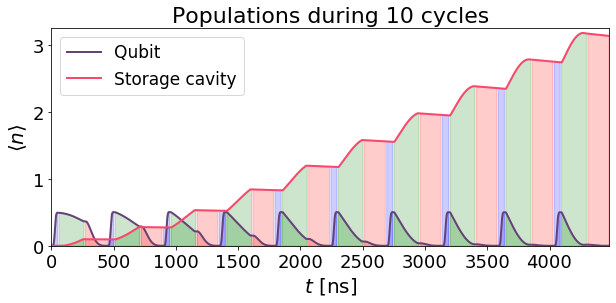

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(times, expect[0], color=plotcolours['qubit'], label='Qubit')
for i in range(N_repeat):
    plt.fill_between(times[int((i*t6+t0)):int((i*t6+t1))], expect[0][int((i*t6+t0)):int((i*t6+t1))], alpha=0.2, color='b')
    plt.fill_between(times[int((i*t6+t2)):int((i*t6+t3))], expect[0][int((i*t6+t2)):int((i*t6+t3))], alpha=0.2, color='g')
    plt.fill_between(times[int((i*t6+t4)):int((i*t6+t5))], expect[0][int((i*t6+t4)):int((i*t6+t5))], alpha=0.2, color='r')
plt.plot(times, expect[1], color=plotcolours['cavity1'], label='Storage cavity')
for i in range(N_repeat):
    plt.fill_between(times[int((i*t6+t0)):int((i*t6+t1))], expect[1][int((i*t6+t0)):int((i*t6+t1))], alpha=0.2, color='b')
    plt.fill_between(times[int((i*t6+t2)):int((i*t6+t3))], expect[1][int((i*t6+t2)):int((i*t6+t3))], alpha=0.2, color='g')
    plt.fill_between(times[int((i*t6+t4)):int((i*t6+t5))], expect[1][int((i*t6+t4)):int((i*t6+t5))], alpha=0.2, color='r')
plt.xlim([0, max(times)])
plt.ylim([0, 3.25])
plt.xlabel("$t$ [ns]")
# plt.ylabel("$n_{}$".format(obj))
plt.ylabel("$\\left<n\\right>$")
plt.legend(loc='upper left')
plt.title("Populations during {} cycles".format(N_repeat))
plt.show()